<h1> WFSS MIRAGE enabled extraction

V. 1.3 Nor Pirzkal 12/22/2021

This notebook demonstrates a basic implementation of Simulation Based Extraction (Pirzkal 2017), which is a way to extract grism from crowded fields. The method relies on two main things: 1) a grismconf type module that allows one to map the dispersion of the grism 2) A way to simulate data a-priori. This can be based on imaging photometry and morphological information about each sources. In this notebook, we use the simulations produced from Mirage (SBE products) which can be saved as a full observed simulation can be produced.

jwst pipeline needs to be installed in order to have access to the jwst datamodel (pip install git+https://github.com/spacetelescope/jwst)

In [1]:
import matplotlib.pyplot as plt

In [2]:
from jwst import datamodels
from scipy.stats import binned_statistic_2d
import os
from astropy.visualization import simple_norm
import h5py
import numpy as np
from astropy.io import fits

<h2> These data are JADES based simulation of a deep field observed with NIRCAM Module A, Grism R, F356W cross filter

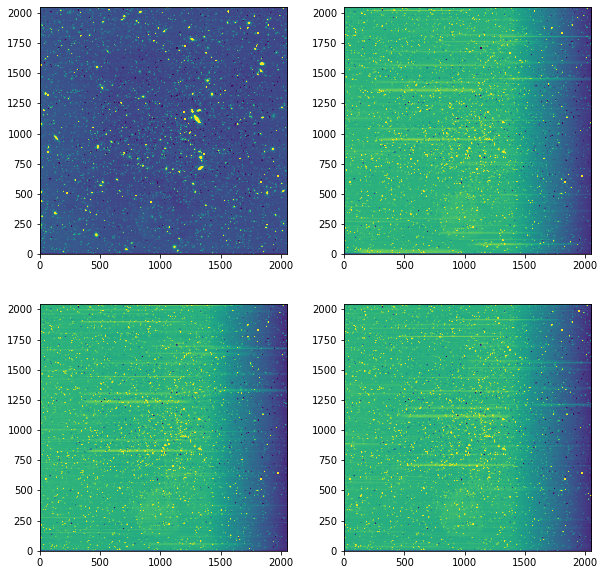

In [3]:
plt.rcParams["figure.figsize"] = (10,10)

plt.subplot(2,2,1)
d = fits.open("./data/jw00042002001_01101_00004_nrca5_rate.fits")[1].data
im = plt.imshow(d,origin="lower")
im.set_clim(0,.3)

plt.subplot(2,2,2)
d = fits.open("./data/jw00042002001_01101_00001_nrca5_rate.fits")[1].data
im = plt.imshow(d,origin="lower")
im.set_clim(0,.3)

plt.subplot(2,2,3)
d = fits.open("./data/jw00042002001_01101_00002_nrca5_rate.fits")[1].data
im = plt.imshow(d,origin="lower")
im.set_clim(0,.3)

plt.subplot(2,2,4)
d = fits.open("./data/jw00042002001_01101_00003_nrca5_rate.fits")[1].data
im = plt.imshow(d,origin="lower")
im.set_clim(0,.3)

plt.rcParams["figure.figsize"] = (10,7)


<h2> The following perform a single rate file extraction. It includes background subtraction

The following function takes the RA and Dec of a source, and the name of a rate file. We use the SBE products from Mirage. These contain the individual simulation of each known source in the field. If we were to use real data, we would simply generate these by using Mirage to model our actual observations.



In [4]:
def extract(ID,ra0,dec0,dataname):
    import os
    import h5py
    import numpy as np
    from astropy.io import fits
    
    path = os.path.split(dataname)[0]

    with fits.open(dataname) as fin:
        h = fin[0].header
        
    # Find some information about the observing mode of this rate file.
    filt = h["FILTER"] # Filter name, e.g. F410M
    grism = h["PUPIL"][-1] # R or C
    module = h["MODULE"] # Which NIRCAM module, A or B
    print("Filter:",filt)
    print("grism:",grism)
    print("Module:",module)
    dataset = '_'.join(os.path.split(dataname)[-1].split("_")[0:4])

    # Name of the SBE saves file. Assumes to be in a sub-directory called SBE_save
    h5name = os.path.join(path,"SBE_save/{}_stamps.hdf5".format(dataset))

    # We load a model of the background for this combination of Module, Filter and grism
    bck = fits.open("./data/GRISMCONF/GRISMDATA/NIRCAM/{}_mod{}_{}_back.fits".format(filt,module,grism))[0].data

    # We initialize a datamodel WCS to the data
    grism_with_wcs = datamodels.open(dataname)

    world_to_pix = grism_with_wcs.meta.wcs.get_transform('world','detector')
    pix_to_world = grism_with_wcs.meta.wcs.get_transform('detector','world')

    # Compute the position of the source in the image in  pixel coordinates
    x0, y0, t, tt = world_to_pix(ra0,dec0,0,0)
    
    print(dataname,"Target is at ",x0,y0)

    # We will need the gain file since data are not in e-/s
    if module=='A':
        gainfile = os.path.expandvars("./data/reference_files/gain/NRCA5_17158_Gain_ISIMCV3_2016-01-23_ssbgain_DMSorient.fits")
    if module=='B':
        gainfile = os.path.expandvars("./data/reference_files/gain/NRCB5_17161_Gain_ISIMCV3_2016-02-25_ssbgain_DMSorient.fits")
    gain = fits.open(gainfile)[1].data

    
    # We use our simulation to figure our where our spectrum is, approximately.
    # models will be an array  containinig ALL of the spectra from all of the sources
    # model0 is an image containing only a simulation of our target
    # Note that models-model0 will therefore be what we think contamination is.
    models = np.zeros(np.shape(bck),np.float)
    stp = h5py.File(h5name,"r")
    minx0 = None
    for k in list(stp.keys()):
        minx = stp[k].attrs["minx"]
        maxx = stp[k].attrs["maxx"]
        miny = stp[k].attrs["miny"]
        maxy = stp[k].attrs["maxy"]
        m = stp[k][:] 
        models[miny:maxy+1,minx:maxx+1] += m 

        if k=="{}_+1".format(ID):
            model0 = m
            minx0 = stp[k].attrs["minx"]
            maxx0 = stp[k].attrs["maxx"]
            miny0 = stp[k].attrs["miny"]
            maxy0 = stp[k].attrs["maxy"]

    stp.close()
    if minx0==None:
        return None

    
    # We load the observation, extimate and subtract the data, masking sources using the Mirage simulation
    data = fits.open(dataname)["SCI"].data * gain
  
    # Create a mask using of model of the whole thing. We mask out any objects with a flux greater  than 0.001 e-/s
    # We also mask part of the image which would be where we know the background is getting very small (10% level of maximum)
    ok = (models<0.001) & (bck>0.1*np.max(bck))
    # The sky level is now just the median of the ratio of our observation and model, when applying the mask we computed
    # to avoid any spectra
    sky_level = np.nanmedian((data/bck)[ok])

    print("Estimated background level:",sky_level)
    
    # We substract the bacvkground from our data
    data = data - sky_level*bck
    # We trim our data to be the stamp containing the spectrum we want to extract
    # Since we use the minx0,maxx0,miny0,maxy0 coordinates from our simulation, this stamp should
    # be just like our simulated data but containing the actual observation.
    data = data[miny0:maxy0+1,minx0:maxx0+1]

    # Same for error array
    err = fits.open(dataname)["ERR"].data*gain
    err = err[miny0:maxy0+1,minx0:maxx0+1]

    # Same for DQ array
    dq = fits.open(dataname)["DQ"].data
    dq = dq[miny0:maxy0+1,minx0:maxx0+1]

    # We estimate of the contamination, from our Mirage simulation of the whole field, as noted
    # above, contamination is just models-model0
    contam = models[miny0:maxy0+1,minx0:maxx0+1] - model0

    # We load trhe grismconf module and load the proper configuration for this NIRCAM mode
    # Description of what grismconf does and how grism calibration  is done is available in 
    # WFC3 ISR 2017-01 from Pirzkal et al. (http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-01.pdf)
    import grismconf
    C = grismconf.Config("./data/GRISMCONF/GRISMDATA/NIRCAM/NIRCAM_{}_mod{}_{}.conf".format(filt,module,grism))
    
    # These are the coordinates of all the pixels in our 2D stamp, but in the full image (wrt calibration is known)
    ys,xs = np.indices((maxy0-miny0+1,maxx0-minx0+1))
    # xs and ys are now the relatice dx and dy offsets from the position of our source
    # They are both 2D arrays of x and y coordinates.
    xs = xs + minx0 - x0
    ys = ys + miny0 - y0

    # Depending on whether the grism disperse in the x or y direction, we use the INVDISPX or INVDISPY functions
    # to compute the value for t for every pixel in our 2D stamps
    if grism=="R":
        ts = C.INVDISPX("+1",x0,y0,xs)
        dys = C.DISPY("+1",x0,y0,ts) + ys
    if grism=="C":
        ts = C.INVDISPY("+1",x0,y0,ys)
        dys = C.DISPX("+1",x0,y0,ts) + xs
    
    # Now compute the wavelength of every pixel in our 2D stamp
    ws = C.DISPL("+1",x0,y0,ts)

    # Now, depending of whether things are in the row or col, we transpose things so that we can look at them 
    # properly (i.e. row direction)
    if grism=="C":
        m = np.transpose(model0) # The model counts in each pixel
        l = np.transpose(ws)     # The wavelength of each pixel
        d = np.transpose(data)   # The data counts in each pixel
        c = np.transpose(contam) # The contamination estimated counts in each pixel
        e = np.transpose(err)    # THe data error estimates in each pixel
        q = np.transpose(dq)     # The data DQ in each pixel
        y = np.transpose(dys)    # The cross-dispersion distance of each pixel from the trace

    if grism=="R":
        m = model0
        l = ws
        d = data
        c = contam
        e = err
        q = dq
        y = dys

    # We now create optimal extraction weights, using our simulation (which accounts for the object profile etc)
    # The extraxction weights are based on the normalized simulated spectral profile at each wavelength
    # Sum up the model in the y-direction and replicate that 
    ysum = np.sum(m,axis=0) 
    w = np.repeat([ysum], np.shape(m)[0], axis=0)
    weight = m/w
    
    # We make sure our original data only has valid data and return everything we computed
    # What we return are no longer 2D stamps but 1D vectors
    ok = np.isfinite(d)
    
    return  d[ok], e[ok], q[ok], l[ok], c[ok], m[ok], weight[ok], y[ok], C



<h2> Extracting a single spectrum from a single rate file

This rate file is the final product of Mirage. It is meant to be a realistic simulation of a real NIRCAM observation of a galaxy field.

In [5]:
ratename = "./data/jw00042002001_01101_00001_nrca5_rate.fits"

<h3> Define the ID of the object we want to extract

We load out catalog and find the RA and DEC of the source

In [6]:
ID = 43416

from astropy.table import Table
cat = Table.read("./data/JWSTSIMS-56.cat",format="ascii")
ok = cat["index"]==ID
ra0 = cat["x_or_RA"][ok][0]
dec0 = cat["y_or_Dec"][ok][0]
print("RA and DEC are:",ra0,dec0)


RA and DEC are: 215.0259085911 52.9307536832


<h3> Run the Extract function

This returns a list of pixels with information about them. We will need to create 2D images from the content of these 1D vectors. We do this using the binned_statistic_2d function. This will allow us to combine different datasets together later.

In [7]:
d, e, q, l, c, m, w, y, C = extract(ID,ra0,dec0,ratename)

Filter: F356W
grism: R
Module: A
./data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1056.4715452078938 1353.8013718337593


2021-12-22 15:45:19,637 - stpipe - WARNING - <ipython-input-4-8d773a2e43cb>:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  models = np.zeros(np.shape(bck),np.float)

2021-12-22 15:45:20,902 - stpipe - WARNING - <ipython-input-4-8d773a2e43cb>:81: RuntimeWarning: invalid value encountered in true_divide
  sky_level = np.nanmedian((data/bck)[ok])



Estimated background level: 1.002096996309166


If we want to look at rectified 2D stamps, we need to bin all these data. The binned_statistic_2d function needs a set of bins, which here are the cross dispersion distance (s, and which relates to y as returned by the extract function) and teh wavelength (bins, which is relates to the l returned by the extract function)

In [8]:
# We go +/- 18 pixels around the trace
dy = 18
s = np.arange(-dy-0.5,dy+0.5+1,1) # bin edges

# We want to bins from 3.05 to 4.11 micron with steps of 10A per bin
bins = np.arange(3.05,4.11, 0.001)

All of the following are 2D stamps, but "rectified" and the x direction of wavelength while y os the cross dispersion distance

In [9]:
# the observation 2D stamp, background subtracted
dd = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(d),bins=[s,bins],statistic="mean")[0]
# errors 2D stamp
ee = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(e),bins=[s,bins],statistic="mean")[0]
# DQ 2D stamp
qq = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(q),bins=[s,bins],statistic="sum")[0]
# Wavelength 2D stamp
ll = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(l),bins=[s,bins],statistic="mean")[0]
# Contamination estimate 2D stamp
cc = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(c),bins=[s,bins],statistic="mean")[0]
# Model 2D stamp
mm = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(m),bins=[s,bins],statistic="mean")[0]
# Extraction weights 2D stamp
ww = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(w),bins=[s,bins],statistic="mean")[0]
# Distance from trace center 2D stamp
yy = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(y),bins=[s,bins],statistic="mean")[0]


We can look at some of this info

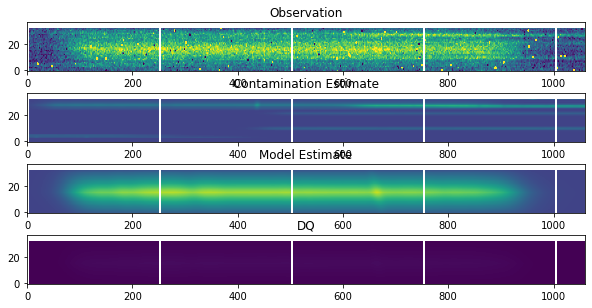

In [10]:
plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(4,1,1)
im = plt.imshow(dd,norm=simple_norm(d,percent=96.),origin="lower",aspect=2.5)
plt.title("Observation")
plt.subplot(4,1,2)
plt.title("Contamination Estimate")
im = plt.imshow(cc,norm=simple_norm(d,percent=96.),origin="lower",aspect=2.5)
plt.subplot(4,1,3)
plt.title("Model Estimate")
im = plt.imshow(mm,norm=simple_norm(d,percent=96.),origin="lower",aspect=2.5)
plt.subplot(4,1,4)
plt.title("DQ")
im = plt.imshow(mm,norm=simple_norm(qq,percent=96.),origin="lower",aspect=2.5)

<h3> Generate 1D spectrum

A 1D spectrum can now generated from the rectified 2D stamps just created. We apply the extraction weights to produce 1D optimally extracted spectrum. 
Here we actually generate a 1D spectrum of simulation of this source as a sanity check

2021-12-22 15:45:21,669 - stpipe - WARNING - <ipython-input-11-4e9477af6e48>:9: RuntimeWarning: invalid value encountered in true_divide
  ext = t1/t2



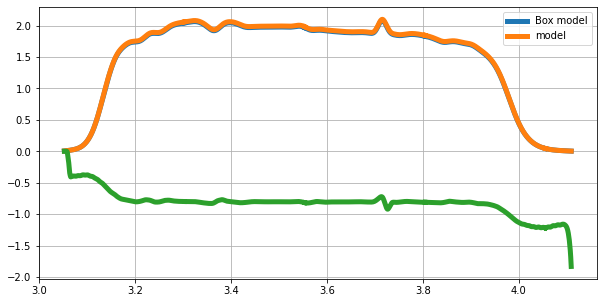

In [11]:
wav = ll[0]

# A box extraction
t0 = np.nansum(mm,axis=0)

# Hornes optimal extraction of model
t1 = np.nansum(mm*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,t0,lw=5,label="Box model")
plt.plot(wav,ext,lw=5,label="model")
plt.grid()
plt.legend()


plt.plot(wav,(t0-ext)/ext*100,lw=5,label="frac. difference x100")



We now generate a 1D spectrum of the observation in exactly the same manner as we  did for the simulation

2021-12-22 15:45:21,914 - stpipe - WARNING - <ipython-input-12-488af7bddce5>:6: RuntimeWarning: invalid value encountered in true_divide
  ext = t1/t2



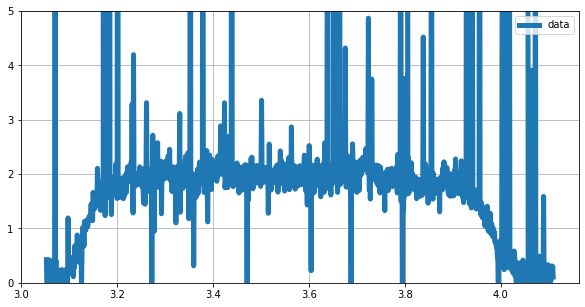

In [12]:
wav = ll[0]

# Hornes optimal extraction of  data-contam
t1 = np.nansum((dd-cc)*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,ext,lw=5,label="data")
plt.legend()
plt.ylim(0,5)
plt.grid()


Looking at observation as well as model

2021-12-22 15:45:22,130 - stpipe - WARNING - <ipython-input-13-98a946e954da>:6: RuntimeWarning: invalid value encountered in true_divide
  ext = t1/t2

2021-12-22 15:45:22,160 - stpipe - WARNING - <ipython-input-13-98a946e954da>:16: RuntimeWarning: invalid value encountered in true_divide
  ext = t1/t2



Text(0, 0.5, 'e/s')

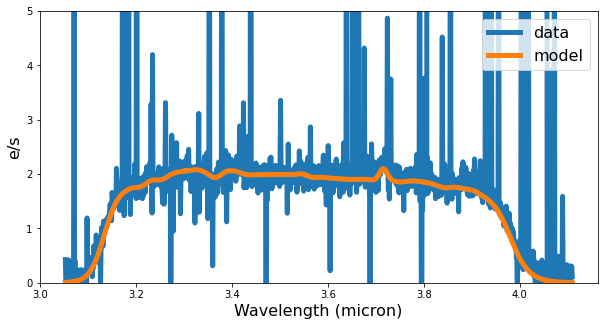

In [13]:
wav = ll[0]

# Hornes optimal extraction of  data-contam
t1 = np.nansum((dd-cc)*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,ext,lw=5,label="data")
plt.legend()
plt.ylim(0,5)
plt.grid()

# Hornes optimal extraction of model
t1 = np.nansum(mm*ww,axis=0)
t2 = np.nansum(ww**2,axis=0)
ext = t1/t2

plt.plot(wav,ext,lw=5,label="model")
plt.legend(fontsize=16)
plt.grid()
plt.xlabel("Wavelength (micron)",fontsize=16)
plt.ylabel("e/s",fontsize=16)

<H3>Extracting and combining multiple observations

Multiple rate files can be processed and combined when more than one rate file is available. The method is the same, and we simply do it for each rate file.

Define the name of the rate files to extract

In [14]:
ratenames = ["jw00042002001_01101_00001_nrca5_rate.fits","jw00042002001_01101_00002_nrca5_rate.fits","jw00042002001_01101_00003_nrca5_rate.fits"]
ratenames = [os.path.join("./data",x) for x in ratenames]

This is a convenience function which simply extract a rectified 2D stamp from each rate file. We end up with several data, odel, contamination etc.. 2D rectified 2D stamps, which we then median to get a final version.

In [15]:

def extract_multiple(ID,ra0,dec0,ratenames):
    dd = []
    ee = []
    qq = []
    ll = []
    cc = []
    mm = []
    ww = []
    yy = []
    rs = []


    dy = 50
    s = np.arange(-dy-0.5,dy+0.5+1,1) 
    bins = np.arange(3.05,4.12, 0.001)


    for i,ratename in enumerate(ratenames):
        print("Doing ",ratename,i+1,"of",len(ratenames))
        res = extract(ID,ra0,dec0,ratename)    
        if res==None:
            return None,None,None,None,None,None
        d, e, q, l, c, m, w, y, C = res

        # We ignore any pixels that had bad DQ to start with
        ok = (np.isfinite(d)) & (np.isfinite(l)) & (q==0)

        d = d[ok]
        e = e[ok]
        q = q[ok]
        l = l[ok]
        c = c[ok]
        m = m[ok]
        w = w[ok]
        y = y[ok]

        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(d),bins=[s,bins],statistic="mean")
        dd.append(tmp[0])

        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(d),bins=[s,bins],statistic="std")
        ee.append(tmp[0])

        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(q),bins=[s,bins],statistic="mean")
        qq.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(l),bins=[s,bins],statistic="mean")
        ll.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(c),bins=[s,bins],statistic="mean")
        cc.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(m),bins=[s,bins],statistic="mean")
        mm.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(w),bins=[s,bins],statistic="mean")
        ww.append(tmp[0])


        tmp = binned_statistic_2d(np.ravel(y),np.ravel(l),np.ravel(y),bins=[s,bins],statistic="mean")
        yy.append(tmp[0])

    # Combine all of the rectified 2D stamps (they are by design in the same wavelength scale)
    dd = np.array(dd)
    cc = np.array(cc)
    mm = np.array(mm)
    ll = np.array(ll)
    yy = np.array(yy)

    
    fd = np.nanmedian(dd,axis=0)
    fc = np.nanmean(cc,axis=0)
    fm = np.nanmean(mm,axis=0)
    fl = np.nanmean(ll,axis=0)
    lam = np.nanmedian(fl,axis=0)
    fy = np.nanmean(yy,axis=0)
    
    # We compute extraction weights from the combined rectified 2D stamp.
    ysum = np.nansum(fm,axis=0)
    w = np.repeat([ysum], np.shape(fm)[0], axis=0)
    fw = fm/w

    return fd,fc,fm,fw,fl,C




<h3> Extract multiple rate files

In [16]:
fd,fc,fm,fw,fl,C = extract_multiple(ID,ra0,dec0,ratenames)

Doing  ./data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
./data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  1056.4715452078938 1353.8013718337593


2021-12-22 15:45:22,748 - stpipe - WARNING - <ipython-input-4-8d773a2e43cb>:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  models = np.zeros(np.shape(bck),np.float)

2021-12-22 15:45:23,917 - stpipe - WARNING - <ipython-input-4-8d773a2e43cb>:81: RuntimeWarning: invalid value encountered in true_divide
  sky_level = np.nanmedian((data/bck)[ok])



Estimated background level: 1.002096996309166
Doing  ./data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
./data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  1176.1812032210682 1234.638357744204
Estimated background level: 0.9940412707358777
Doing  ./data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
./data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  1295.5418315653237 1115.606375857987
Estimated background level: 0.994329784691824


2021-12-22 15:45:46,630 - stpipe - WARNING - /Users/npirzkal/opt/anaconda3/envs/mirage/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,

2021-12-22 15:45:46,693 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:75: RuntimeWarning: Mean of empty slice
  fc = np.nanmean(cc,axis=0)

2021-12-22 15:45:46,697 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:76: RuntimeWarning: Mean of empty slice
  fm = np.nanmean(mm,axis=0)

2021-12-22 15:45:46,702 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:77: RuntimeWarning: Mean of empty slice
  fl = np.nanmean(ll,axis=0)

2021-12-22 15:45:46,711 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:79: RuntimeWarning: Mean of empty slice
  fy = np.nanmean(yy,axis=0)



Just as before, we can use the extraction weigths and generate a 1D model spectrum

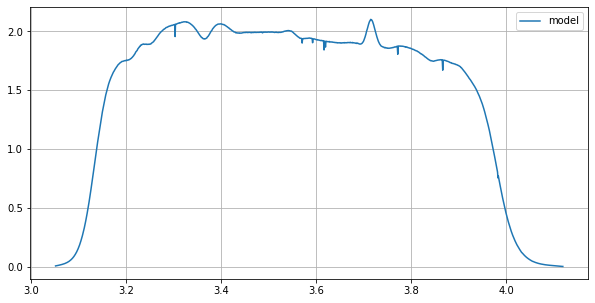

In [17]:
lam = np.nanmean(fl,axis=0)

# Hornes optimal extraction of model
t1 = np.nansum(fm*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
ext0 = t1/t2
plt.plot(lam,ext0,label="model")

plt.grid()
plt.legend()



Generate a 1D spectrum of our observation

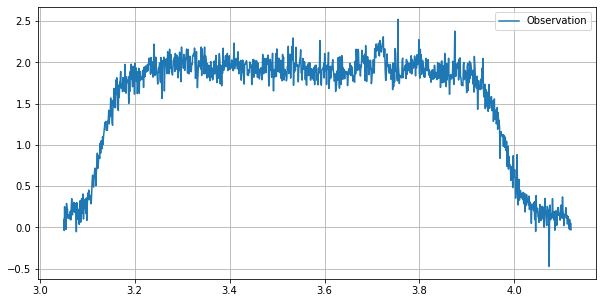

In [18]:
lam = np.nanmean(fl,axis=0)

# Hornes optimal extraction of model
t1 = np.nansum((fd-fc)*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
ext0 = t1/t2
plt.plot(lam,ext0,label="Observation")
plt.grid()
plt.legend()


Model and observations together

Text(0, 0.5, 'e/s')

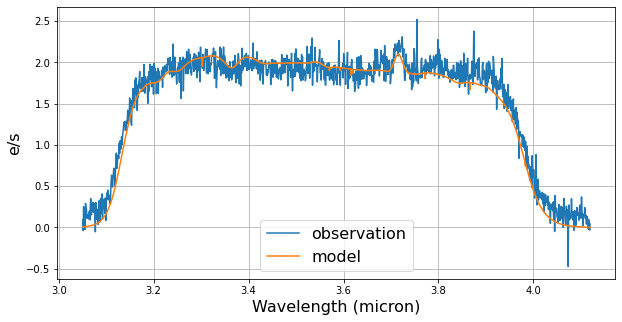

In [19]:
lam = np.nanmean(fl,axis=0)


# Hornes optimal extraction of model
t1 = np.nansum((fd-fc)*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
opt_extracted = t1/t2
plt.plot(lam,opt_extracted,label="observation")

t1 = np.nansum(fm*fw,axis=0)
t2 = np.nansum(fw**2,axis=0)
ext0 = t1/t2
plt.plot(lam,ext0,label="model")
plt.grid()
plt.legend(fontsize=16)
plt.xlabel("Wavelength (micron)",fontsize=16)
plt.ylabel("e/s",fontsize=16)


<h3> Flux calibrate and compare to input spectrum

So far, we have generated rectified 2D stamps and generated wavelength calibrated 1D spectra, but still need to flux calibrate them by applying the grism sensitivity function

For reference, we load the original spectrum used when running Mirage. Our extraction of the simulation should match

In [20]:
#ref = h5py.File("./data/CEERS_JADES3_galaxies.hdf5","r")
with h5py.File("./data/JWSTSIMS-56.h5","r") as ref:
    w0,f0 = ref["{}".format(ID)]


Apply sensitivity to extracted spectrum

2021-12-22 15:45:47,458 - stpipe - WARNING - <ipython-input-21-78fe2482c3df>:2: RuntimeWarning: divide by zero encountered in true_divide
  flux = opt_extracted/s /10



Text(0, 0.5, '$erg/s/cm^2/A$')

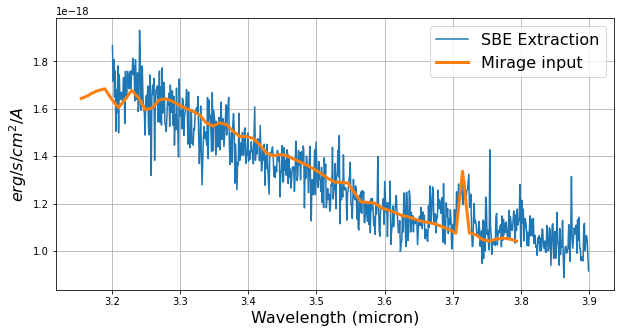

In [21]:
s = C.SENS["+1"](lam)
flux = opt_extracted/s /10

ok = (lam>3.2) & (lam<3.9)
plt.plot(lam[ok],flux[ok],label="SBE Extraction")


ok = (w0>3.15) & (w0<3.8)
plt.plot(w0[ok],f0[ok],lw=3,label="Mirage input")
plt.grid()
plt.legend(fontsize=16)
plt.xlabel("Wavelength (micron)",fontsize=16)
plt.ylabel(r'$erg/s/cm^2/A$',fontsize=16)



<h3>Putting it all together

This simply runs the extraction and output results (plot and table) in the directory opath

In [22]:
def extract_ID(ID,catalog,ratenames,opath="/tmp/"):
    from astropy.table import Table
    
    if os.path.isfile(os.path.join(opath,"{}.done".format(ID))):
        print(ID,"aready extracted")
        return
        
    cat = Table.read(catalog,format="ascii")
    ok = cat["index"]==ID
    ra0 = cat["x_or_RA"][ok][0]
    dec0 = cat["y_or_Dec"][ok][0]
    print("RA and DEC are:",ra0,dec0)



    fd,fc,fm,fw,fl,C = extract_multiple(ID,ra0,dec0,ratenames)
    if fd is None:
        return
    
    lam = np.nanmean(fl,axis=0)

    # Hornes optimal extraction of data
    t1 = np.nansum((fd-fc)*fw,axis=0)
    t2 = np.nansum(fw**2,axis=0)
    opt_extracted = t1/t2
    
    s = C.SENS["+1"](lam)
    flux_opt_extracted = opt_extracted/s /10 # 10A per pixel

    # Hornes optimal extraction of model
    t1 = np.nansum(fm*fw,axis=0)
    t2 = np.nansum(fw**2,axis=0)
    ext0 = t1/t2
    ext0_opt_extracted = ext0/s /10 # 10A per pixel


    plt.clf()
    plt.figure(figsize=(15,5))
    plt.subplot(2,1,1)
    plt.plot(lam,opt_extracted,label="observation")
    plt.plot(lam,ext0,label="model")
    plt.grid()
    plt.legend()
    plt.xlabel("Wavelength (A)")
    plt.ylabel("e-/s")
    plt.savefig(os.path.join(opath,"{}.pdf".format(ID)))

    res = Table()
    res["LAMBDA"] = lam
    res["Flux"] = opt_extracted
    res["Model"] = ext0
    res.write(os.path.join(opath,"{}.table".format(ID)),format="ascii")
    
    open(os.path.join(opath,"{}.done".format(ID)),"w").writelines([])

RA and DEC are: 215.0496555911 52.9268016832
Doing  ./data/jw00042002001_01101_00001_nrca5_rate.fits 1 of 3
Filter: F356W
grism: R
Module: A
./data/jw00042002001_01101_00001_nrca5_rate.fits Target is at  234.062600977261 1123.1279012507716


2021-12-22 15:45:48,482 - stpipe - WARNING - <ipython-input-4-8d773a2e43cb>:50: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  models = np.zeros(np.shape(bck),np.float)

2021-12-22 15:45:49,677 - stpipe - WARNING - <ipython-input-4-8d773a2e43cb>:81: RuntimeWarning: invalid value encountered in true_divide
  sky_level = np.nanmedian((data/bck)[ok])



Estimated background level: 1.002096996309166
Doing  ./data/jw00042002001_01101_00002_nrca5_rate.fits 2 of 3
Filter: F356W
grism: R
Module: A
./data/jw00042002001_01101_00002_nrca5_rate.fits Target is at  354.75343388628187 1005.0898773164137
Estimated background level: 0.9940412707358777
Doing  ./data/jw00042002001_01101_00003_nrca5_rate.fits 3 of 3
Filter: F356W
grism: R
Module: A
./data/jw00042002001_01101_00003_nrca5_rate.fits Target is at  475.22340853124035 887.1427313522893
Estimated background level: 0.994329784691824


2021-12-22 15:45:56,981 - stpipe - WARNING - /Users/npirzkal/opt/anaconda3/envs/mirage/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,

2021-12-22 15:45:57,062 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:75: RuntimeWarning: Mean of empty slice
  fc = np.nanmean(cc,axis=0)

2021-12-22 15:45:57,066 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:76: RuntimeWarning: Mean of empty slice
  fm = np.nanmean(mm,axis=0)

2021-12-22 15:45:57,071 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:77: RuntimeWarning: Mean of empty slice
  fl = np.nanmean(ll,axis=0)

2021-12-22 15:45:57,080 - stpipe - WARNING - <ipython-input-15-5824da4f552c>:79: RuntimeWarning: Mean of empty slice
  fy = np.nanmean(yy,axis=0)

2021-12-22 15:45:57,088 - stpipe - WARNING - <ipython-input-22-742fd3c2c7d9>:20: RuntimeWarning: Mean of empty slice
  lam = np.nanmean(fl,axis=0)

20

<Figure size 720x360 with 0 Axes>

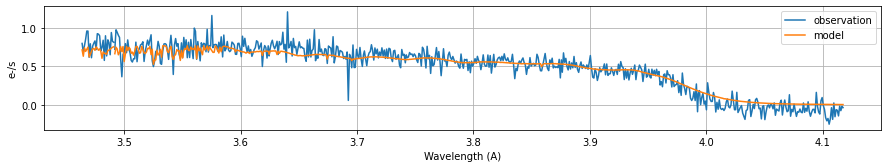

In [23]:
catalog = "./data/JWSTSIMS-56.cat"
extract_ID(14923,catalog,ratenames)